# Features Extraction & Clustering. Part IV.
This extra-part of final report aims to provide comparison of clusters obtained with different methods and give recommendations on steps for possible improvements of created pipeline and further research. 

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
from comparison import comparison, normalize
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import combinations
import hdbscan

New **comparison()** function from **comparison.py** file just runs clustering with our own feature extraction algorithm exactly as it was done in previous parts of this report. This function was implemented just to make this report cleaner and more readable.

In [3]:
%%time
n_clusters_, top_level_clusters, top_level_outliers, ef_norm = comparison()

Feature Extraction: 100%|███████████████████████████████| 20/20 [28:14<00:00, 84.71s/it]


Wall time: 43min 32s


# Visualization of clusters
There are several reasons why compare clusters obtained by different methods (basic clustering and tsfresh clustering) is unsuitable. Main of them are:
1. Metrics used by each approach are different
2. There were no top-level clusters in case of tsfresh

In case of tsfresh-based clustering we facing a problem of high dimensionality that doesn't allow to view coins as points in space. Nevetheless we can make simplified visualization of clusters as graph, that consists of connected subgraphs. Each subgraph represents corresponding cluster with all nodes mutually connected.

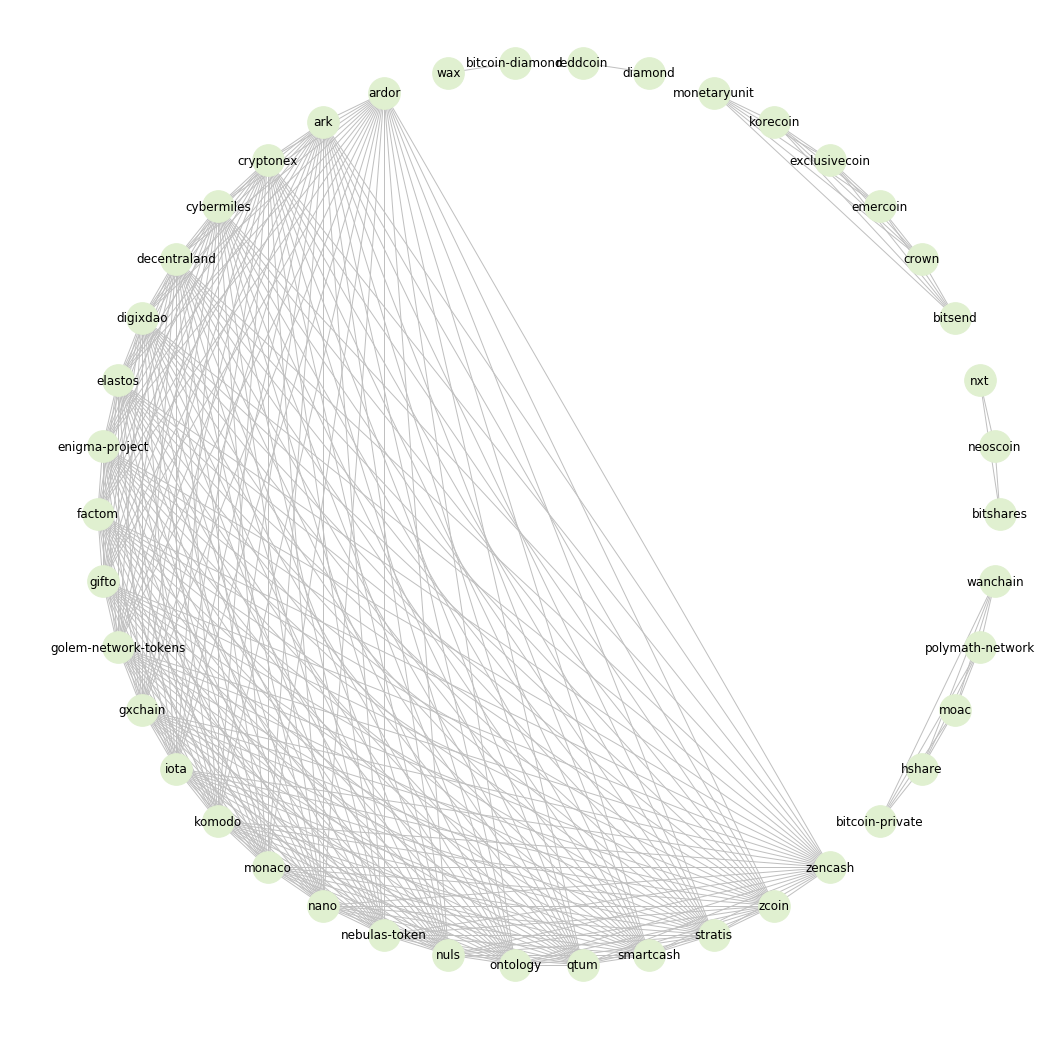

In [4]:
tf_clusterer = hdbscan.HDBSCAN(min_cluster_size=2)
tf_labels = tf_clusterer.fit_predict(ef_norm)
ef_norm['label'] = tf_labels

G=nx.Graph()

for label in np.unique(tf_labels):
    if label != -1:
        cl_tf = ef_norm[ef_norm['label'] == label]
        nodes = cl_tf.index.values.tolist()
        edges = combinations(nodes, 2)
        g = nx.Graph()
        g.add_nodes_from(nodes)
        g.add_edges_from(edges)
        G = nx.compose(G,g)
    
plt.figure(0, figsize=(14,14))
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels = True, font_size=12, node_color='#E0F0D0', edge_color='#C0C0C0', node_size=1000)
plt.show()

Circular form observed because of passing corresponding **pos** argument to networkx. This will improve graph nodes readability.

# Clusters comparison
In case of using our own implementatin of basic features extraction we can make much more interesting results. We have several top-level clusters. We performed several clusterings: for the whole timeline, and for timelines corresponding to different market states. Each time we obtained different clusters because of different similarities between coins for each case. We can visualize coins of each top-level cluster as nodes and connect them with edges obtained in all four cases (all, bullish, bearish, stable).


Top level cluster label 0:


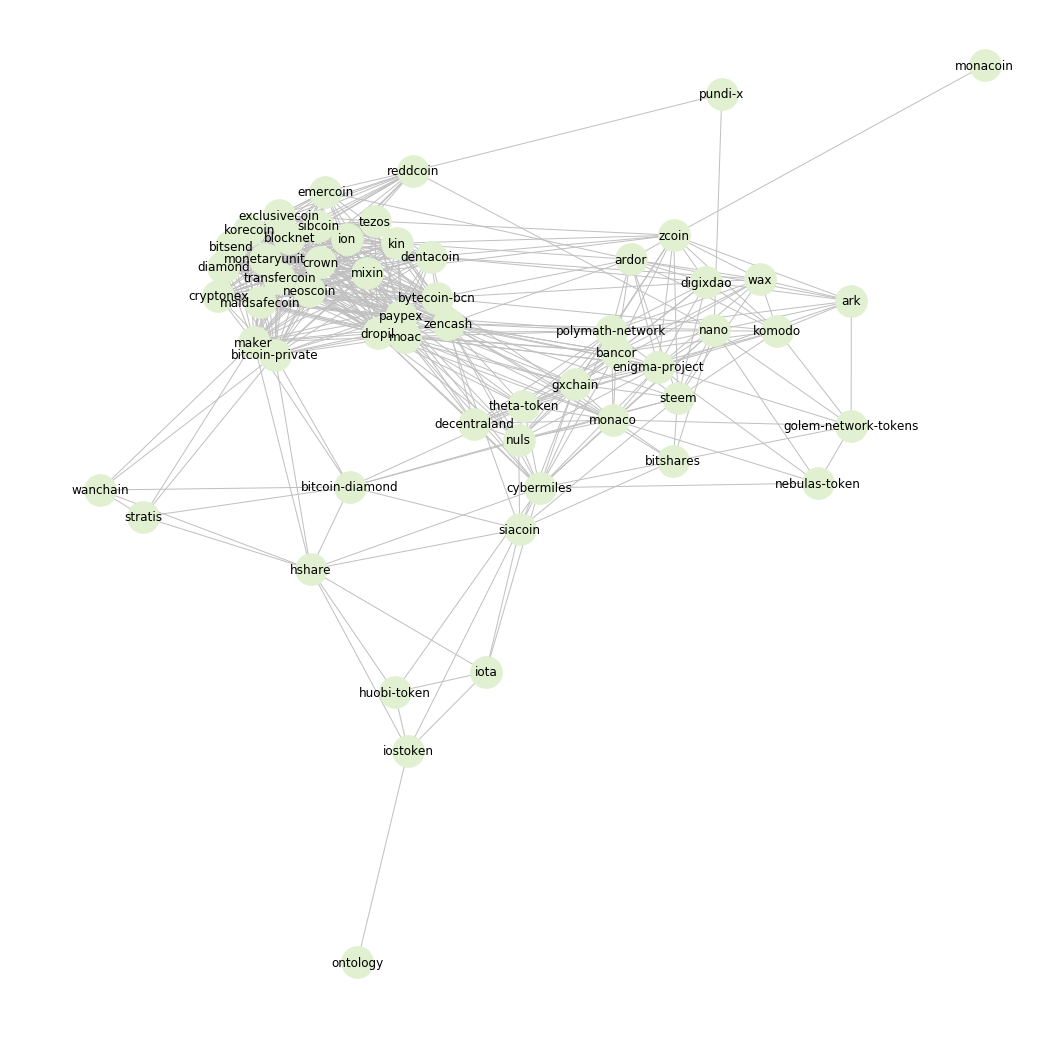


Top level cluster label 1:


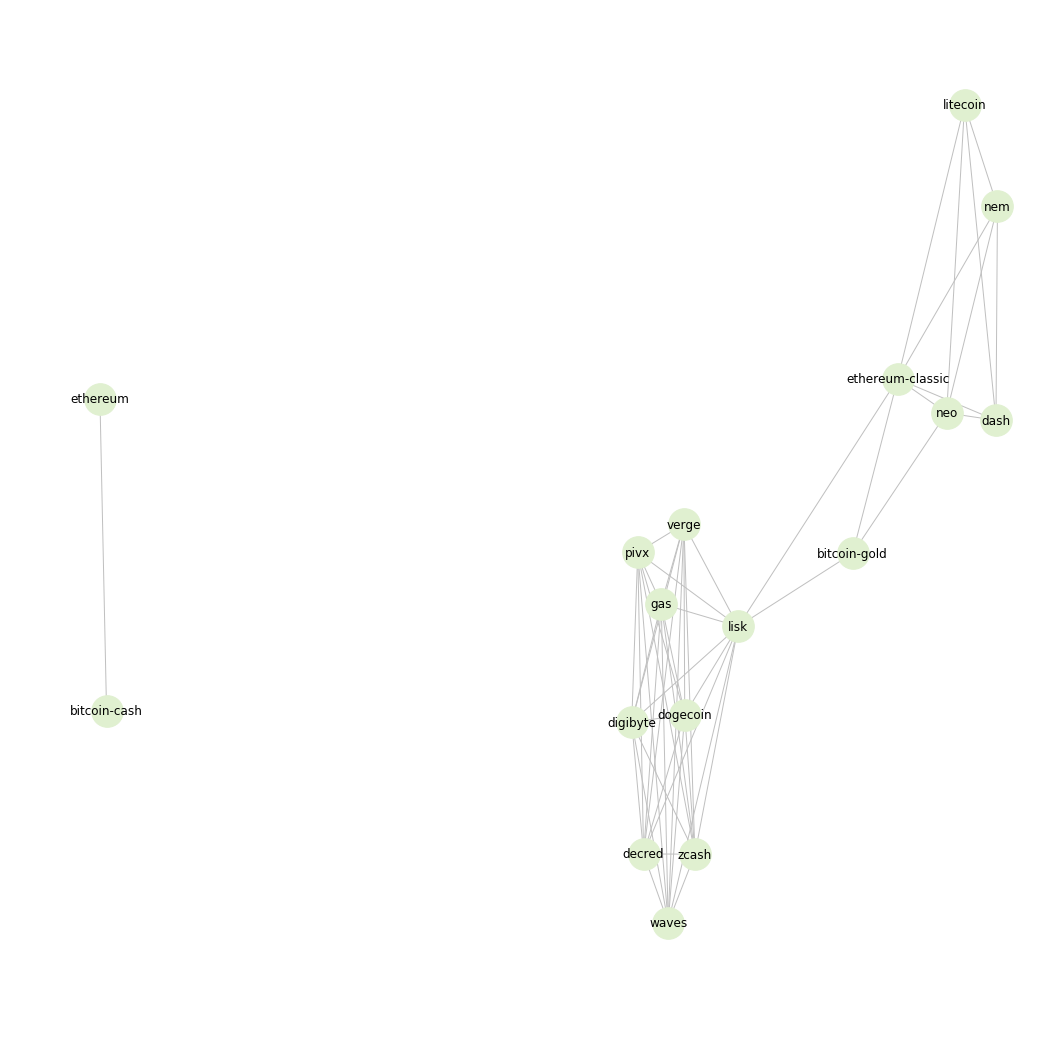


Top level cluster label 2:


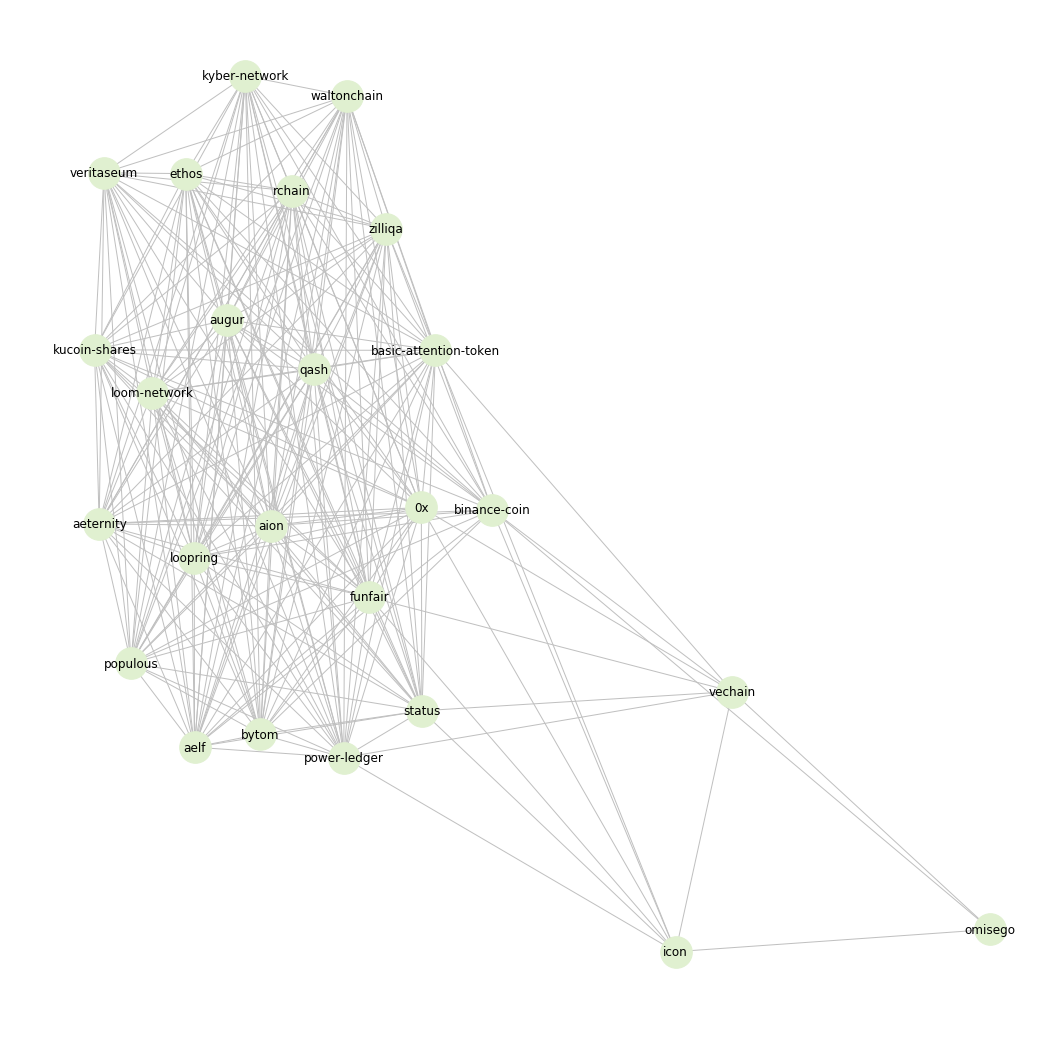

In [5]:
for cl_num in range(n_clusters_):
    
    G=nx.Graph()
    should_draw = False
    for cl_type in top_level_clusters:
        tc = top_level_clusters[cl_type][cl_num]
        tc = tc.replace([np.inf, -np.inf], np.nan)
        tc = tc.dropna(axis='rows', how='all')
        tc = tc.dropna(axis='columns', how='any')
        
        if tc.shape[1] > 0 and tc.shape[0] > 2:
            clusterer = hdbscan.HDBSCAN(min_cluster_size=2)
            ll_labels = clusterer.fit_predict(tc)
            tc['label'] = ll_labels
            unclustered_coins = set()

            for label in np.unique(ll_labels):
                if label != -1:
                    should_draw = True
                    cl = tc[tc['label'] == label]
                    nodes = cl.index.values.tolist()
                    edges = combinations(nodes, 2)
                    g = nx.Graph()
                    g.add_nodes_from(nodes)
                    g.add_edges_from(edges)
                    G = nx.compose(G,g)
                else:
                    noise_coins = tc[tc['label'] == label].index.values.tolist()
                    unclustered_coins.update(noise_coins)
        else:
            unclustered_coins.update(tc.index.values.tolist())
    if should_draw:
        print("="*120)
        print()
        print("Top level cluster label {}:".format(cl_num))
        plt.figure(cl_num + 1,figsize=(14,14))
        pos = nx.circular_layout(G)
        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels = True, font_size=12, node_color='#E0F0D0', edge_color='#C0C0C0', node_size=1000)
        plt.show()

## Important notes

These graphs amply describes relations between different coins, taking in account different clustering approaches. It's important to understand that several factors:

- All coins inside cluster are connected a priori between each other. This mean that special attention should be given to coins lying on the border of dense regions and it's connections.
- Graphs do not take into account **real distance** between coins, they just illustrate **which** coins are connected, but not **how** they are connected. 
- While one particular method consider some coin as outlier, other method can find it in a cluster with others at the same time. This will lead to presence of corresponding node on the graph
- Coins considered as outliers are not presented on the graph

# Further research recommendations on research improvement

First of all, clustering results obtained is not as much important result as creation of working pipeline for research. And first steps of results improving should be taken by tuning and polishing parts of this pipeline. There are several directions to work on. **The most important advantage of created pipeline is ability to make following improvments independently as well as in combination**.

## 1. Handling NAs
Of course the step that always should be taken first is try to get the data when it actually exist but missed.
We used linear interpolation on couple of steps. It can be easily changed to [number of different methods][1].

## 2. Detection of market states
There are several possibilities of improving the function of states detection. One of the major ways is to add some measure of "market sluggishness" or "sensivity" to allow prolongation of detected periods over small jumps of price.
Another way is use moving-average-based algorithms that will catch the state in very similar way like the market does.
Probably gradation of market states can include more than three states.

## 3. Tuning of DBSCAN
Studying of metrics and distances found by HDBSCAN.

## 4. Tsfresh tuning
### 4.1. Variables importance for tsfresh
It's possible to use random forest to detect what features influence the most to obtain such clustering result.
### 4.2. High dimensionality
High dimensionality is not bad itself. Tsfresh just extracts a lot of parameters (~800) for each time serie. Additionally we have 22 params describing each coin. Probably the best way is to accurately study the output of tsfresh and first of all manually (with common sense) exclude redundant parameters. It's likely that this will leave us with suitable number of dimensions. After that we can use some algorithmic approach to reduce dimensionality if it will be necessary.

## 5. Combine tsfresh with market states
Probably tuned tsfresh-based approach in combination with upgraded function of finding market states can bring especially accurate results on clustering.

## 6. Visualization
It's possible to improve clusters visualizations by drawing multigraphs instead of regular graphs, This will allow to draw multiple edges between nodes. 

# Alternative vision
Having more time it's possible to make **really deep study** using **DTW**-based approach. Technique reviewed in [this presentation][2] can be the base for alternative researh that can reveal not only coins similarities but also provide serious prepositions for predictive analysis. I strongly recommend to study this publication very accurately. 

[1]:https://docs.scipy.org/doc/scipy/reference/interpolate.html#module-scipy.interpolate
[2]:http://www.cs.unm.edu/~mueen/DTW.pdf